# Setup

In [100]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from matplotlib_venn import venn3, venn2
import random
import plotly.io as pio
from scipy import sparse
import os
import networkx as nx

In [101]:
seed = 16
random.seed(seed)
np.random.seed(seed)

#esto es para forzar a plt a poner fondos blancos en las figuras aunque el tema del notebook sea oscuro
#plt.rcParams['axes.facecolor'] = 'white'
#plt.rcParams['figure.facecolor'] = 'white'
cmap = plt.get_cmap("tab10")
pio.templates.default = "seaborn"

sns.set_style("darkgrid", rc={'xtick.bottom': True})

In [102]:
data_processed = "../../../data/processed/"
data_interim = "../../../data/interim/"
data_external = "../../../data/external/"
tfidf_reports = "../../../reports/tfidf/"
reports_comunidades = "../../../reports/analisis_comunidades/"
reports_jaccard = "../../../reports/jaccard_gene_similarity/"

In [103]:
def get_node_dict(G):
    return {node:data for (node,data) in list(G.nodes(data=True))}

def node_labels_to_numeric(G):
    new_labels = {old_label:int(old_label) for old_label in list(G.nodes)}
    nx.relabel_nodes(G,new_labels,False)

In [104]:
graph_node_data = pd.read_csv(data_processed+"graph_data/grafo_alternativo_CG_nodos.csv")
G = nx.read_gml(data_processed+"graph_data/gda_network.gml")
node_labels_to_numeric(G)

nodos_gda = pd.DataFrame(get_node_dict(G)).T.reset_index().rename(columns={"index":"node_index"})
nodos_enfermedad = nodos_gda.loc[nodos_gda.node_type == "disease", "node_index"].values

In [105]:
nodos_gda

,node_index,node_type,node_name,node_id,node_source
0,33368,disease,PERRAULT SYNDROME 6,C4479656,disgenet
1,11771,gene_protein,PDGFC,56034,disgenet
2,19156,disease,Dry Eye Syndromes,C0013238,disgenet
3,24192,disease,Acrodermatitis continua of Hallopeau,C0392439,disgenet
4,22295,disease,Fine Tremor,C0234373,disgenet
...,...,...,...,...,...
20851,32900,disease,Hyperinsulinism due to HNF4A deficiency,C4274078,disgenet
20852,10565,gene_protein,PLTP,5360,disgenet
20853,24318,disease,Primary immune deficiency disorder,C0398686,disgenet
20854,32,gene_protein,MIR875,100126309,disgenet


# Jaccard de genes compartidos

Ver para clusters asociados con cancer. Ver para casos no nulos (dirección inversa).

In [141]:
def jaccard(set1,set2):
    intersection = len(set1&set2)
    union = len(set1|set2)
    return round(intersection/union,2)

def overlap(set1,set2):
    intersection = len(set1&set2)
    min_set = min([len(set1),len(set2)])
    return intersection/min_set

In [107]:
conjuntos_enfermedad = {}

for enfermedad in nodos_enfermedad:
    vecinos = list(G.neighbors(enfermedad))
    conjuntos_enfermedad[enfermedad] = set(vecinos)

In [108]:
matrix_jaccard = np.zeros((len(nodos_enfermedad), len(nodos_enfermedad)))

In [109]:
for i in range(len(nodos_enfermedad)):
    for j in range(len(nodos_enfermedad)):
        nodo_i = nodos_enfermedad[i]
        nodo_j = nodos_enfermedad[j]
        conjunto_i = conjuntos_enfermedad[nodo_i]
        conjunto_j = conjuntos_enfermedad[nodo_j]
        coef = jaccard(conjunto_i, conjunto_j)
        matrix_jaccard[i,j] = coef

In [112]:
sparse_jaccard = sparse.csr_matrix(matrix_jaccard)
# sparse.save_npz(reports_jaccard+"jaccard_sparse_matrix.npz",sparse_jaccard)
df_jaccard_sparse = pd.DataFrame.sparse.from_spmatrix(sparse_jaccard, index=nodos_enfermedad, columns=nodos_enfermedad)

In [142]:
matrix_overlap = np.zeros((len(nodos_enfermedad), len(nodos_enfermedad)))

for i in range(len(nodos_enfermedad)):
    for j in range(len(nodos_enfermedad)):
        nodo_i = nodos_enfermedad[i]
        nodo_j = nodos_enfermedad[j]
        conjunto_i = conjuntos_enfermedad[nodo_i]
        conjunto_j = conjuntos_enfermedad[nodo_j]
        coef = overlap(conjunto_i, conjunto_j)
        matrix_overlap[i,j] = coef

In [145]:
sparse_overlap = sparse.csr_matrix(matrix_overlap)
df_overlap_sparse = pd.DataFrame.sparse.from_spmatrix(sparse_overlap, index=nodos_enfermedad, columns=nodos_enfermedad)
sparse.save_npz(reports_jaccard+"overlap_sparse_matrix.npz",sparse_overlap)

# Similaridad jaccard vs comunidades

## Checkpoint

In [120]:
sparse_jaccard = sparse.load_npz(reports_jaccard+"jaccard_sparse_matrix_2.npz")
df_jaccard_sparse = pd.DataFrame.sparse.from_spmatrix(sparse_jaccard, index=nodos_enfermedad, columns=nodos_enfermedad)

In [121]:
df_jaccard_sparse

,33368,19156,24192,22295,31097,29354,30437,19168,26882,19094,...,27780,18853,33170,25712,28276,19898,26204,32900,24318,33386
33368,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,...,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
19156,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,...,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
24192,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,...,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
22295,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.00,...,0.0,0.04,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
31097,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.00,...,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19898,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,...,0.0,0.00,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
26204,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.03,...,0.0,0.00,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
32900,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,...,0.0,0.00,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
24318,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,...,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [132]:
no_nulos = (sparse_jaccard.nnz - 11167)/2
print(no_nulos)

710168.0


In [9]:
graph_node_data = pd.read_csv(data_processed+"graph_data/grafo_alternativo_CG_nodos.csv")
disease_attributes = pd.read_csv(data_interim+"grafo_alternativo_disease_attributes.csv")

nodos_bert = graph_node_data.loc[graph_node_data.node_type == "bert_group",["node_index","node_id","node_name","node_source"]].copy()
disease_attributes = pd.concat([disease_attributes,nodos_bert])

enfermedades_en_dd = graph_node_data.loc[graph_node_data.degree_dd != 0, "node_index"].values
disease_attributes = disease_attributes.set_index("node_index").loc[enfermedades_en_dd].reset_index()

disease_attributes = pd.merge(graph_node_data[["node_index","comunidades_infomap","comunidades_louvain"]],disease_attributes,left_on="node_index",right_on="node_index",how="right")

tamaños_louvain = disease_attributes.comunidades_louvain.value_counts()
tamaños_infomap = disease_attributes.comunidades_infomap.value_counts()

infomap_clusters = pd.DataFrame(tamaños_infomap).reset_index().rename(columns={"index":"comunidad","comunidades_infomap":"tamaño"}).astype({"comunidad":"int"})
louvain_clusters = pd.DataFrame(tamaños_louvain).reset_index().rename(columns={"index":"comunidad","comunidades_louvain":"tamaño"}).astype({"comunidad":"int"})

In [9]:
infomap_clusters

,comunidad,tamaño
0,3,198
1,354,82
2,188,74
3,416,74
4,436,71
...,...,...
1136,968,2
1137,1060,2
1138,1010,2
1139,1121,2


Ver cantidad de enlaces GDA por comunidad. Puede ser la fracción de enfermedades con mapeo. Con las dos particiones.

De los que tienen enlaces, ver el numero medio de enlaces. 

Reportar las dos cosas.

In [11]:
graph_node_data

,node_index,node_id,node_name,node_type,node_source,comunidades_infomap,comunidades_louvain,degree_gda,degree_pp,degree_dd
0,0,1,A1BG,gene_protein,disgenet,NaN,NaN,2.0,12.0,0.0
1,1,10,NAT2,gene_protein,disgenet,NaN,NaN,39.0,6.0,0.0
2,2,100,ADA,gene_protein,disgenet,NaN,NaN,18.0,5.0,0.0
3,3,1000,CDH2,gene_protein,disgenet,NaN,NaN,28.0,15.0,0.0
4,4,10000,AKT3,gene_protein,disgenet,NaN,NaN,9.0,39.0,0.0
...,...,...,...,...,...,...,...,...,...,...
35864,36633,SIGNOR-C93,MYOD1/SWI/SNF complex,complex,signor,NaN,NaN,0.0,2.0,0.0
35865,36634,SIGNOR-C94,Myog/SWI/SNF complex,complex,signor,NaN,NaN,0.0,2.0,0.0
35866,36635,SIGNOR-C95,CDON/BOC/PTCH1,complex,signor,NaN,NaN,0.0,3.0,0.0
35867,36636,SIGNOR-C97,RBPJ/NOTCH,complex,signor,NaN,NaN,0.0,2.0,0.0


In [17]:
algoritmo = "comunidades_infomap"
cluster = 5
similarity_matrix = df_jaccard_sparse

nodos_cluster = graph_node_data[graph_node_data[algoritmo] == cluster].node_index.values
nodos_disponibles = list(set(nodos_cluster)&set(nodos_enfermedad))
cluster_matrix = similarity_matrix.loc[nodos_disponibles,nodos_disponibles].values

In [136]:
def mean_similarity_triu(similarity_matrix, cluster, algoritmo):
    nodos_cluster = graph_node_data[graph_node_data[algoritmo] == cluster].node_index.values
    nodos_disponibles = list(set(nodos_cluster)&set(nodos_enfermedad))
    cluster_matrix = similarity_matrix.loc[nodos_disponibles,nodos_disponibles].values
    indices = np.triu_indices_from(cluster_matrix,1)
    values = cluster_matrix[indices]
    return round(np.mean(values), 2)

In [137]:
infomap_similarity = pd.Series({cluster:mean_similarity_triu(df_jaccard_sparse, cluster, "comunidades_infomap") for cluster in infomap_clusters.comunidad.values}, name="jaccard_mean_similarity")
louvain_similarity = pd.Series({cluster:mean_similarity_triu(df_jaccard_sparse, cluster, "comunidades_louvain") for cluster in louvain_clusters.comunidad.values}, name="jaccard_mean_similarity")

infomap_clusters = pd.merge(infomap_clusters,infomap_similarity, left_on="comunidad",right_index=True)
louvain_clusters = pd.merge(louvain_clusters,louvain_similarity, left_on="comunidad",right_index=True)

/home/ingrid/.local/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/ingrid/.local/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/ingrid/.local/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/ingrid/.local/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/ingrid/.local/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/ingrid/.local/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = 

Text(0.5, 1.0, 'Louvain')

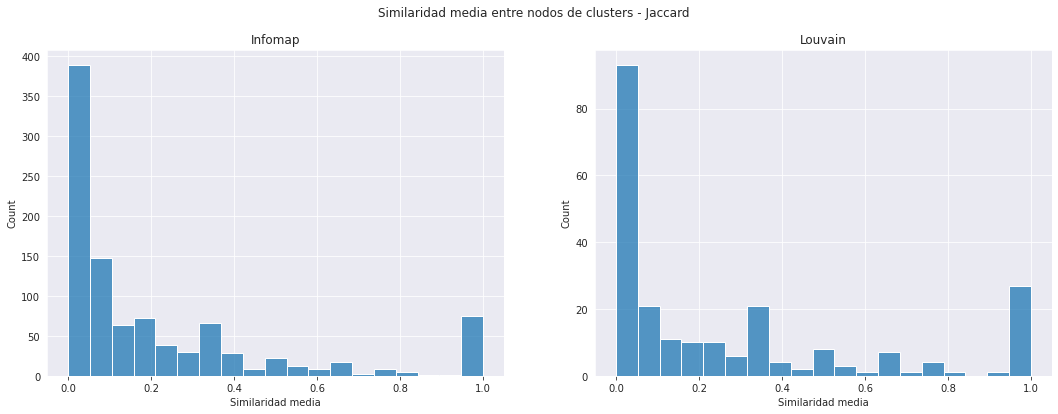

In [138]:
fig, ax = plt.subplots(1,2,figsize=(18,6))
fig.suptitle(f"Similaridad media entre nodos de clusters - Jaccard")

sns.histplot(data=infomap_clusters["jaccard_mean_similarity"], ax=ax[0], bins=np.linspace(0,1,20))
ax[0].set_xlabel("Similaridad media")
ax[0].set_title("Infomap")

sns.histplot(data=louvain_clusters["jaccard_mean_similarity"], ax=ax[1],bins=np.linspace(0,1,20))
ax[1].set_xlabel("Similaridad media")
ax[1].set_title("Louvain")

In [147]:
infomap_overlap = pd.Series({cluster:mean_similarity_triu(df_overlap_sparse, cluster, "comunidades_infomap") for cluster in infomap_clusters.comunidad.values}, name="mean_overlap_coef")
louvain_overlap = pd.Series({cluster:mean_similarity_triu(df_overlap_sparse, cluster, "comunidades_louvain") for cluster in louvain_clusters.comunidad.values}, name="mean_overlap_coef")

infomap_clusters = pd.merge(infomap_clusters,infomap_overlap, left_on="comunidad",right_index=True)
louvain_clusters = pd.merge(louvain_clusters,louvain_overlap, left_on="comunidad",right_index=True)

/home/ingrid/.local/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/ingrid/.local/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/ingrid/.local/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/ingrid/.local/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/ingrid/.local/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/ingrid/.local/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = 

Text(0.5, 1.0, 'Louvain')

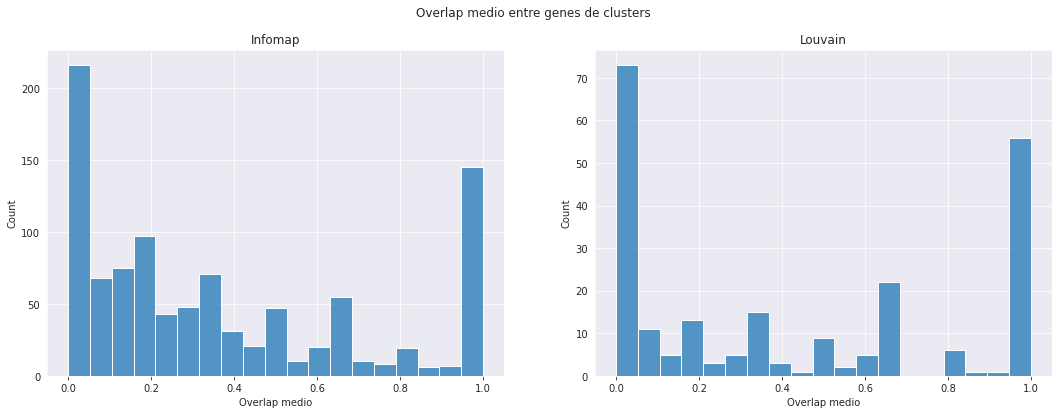

In [151]:
fig, ax = plt.subplots(1,2,figsize=(18,6))
fig.suptitle(f"Overlap medio entre genes de clusters")

sns.histplot(data=infomap_clusters["mean_overlap_coef"], ax=ax[0], bins=np.linspace(0,1,20))
ax[0].set_xlabel("Overlap medio")
ax[0].set_title("Infomap")

sns.histplot(data=louvain_clusters["mean_overlap_coef"], ax=ax[1],bins=np.linspace(0,1,20))
ax[1].set_xlabel("Overlap medio")
ax[1].set_title("Louvain")

# Veo clusters específicos

In [27]:
infomap_cluster_data = pd.read_pickle("../../../reports/tfidf/infomap_analysis_checkpoint.pkl")
louvain_cluster_data = pd.read_pickle("../../../reports/tfidf/louvain_analysis_checkpoint.pkl")

In [36]:
conectividad_infomap = pd.read_csv(reports_comunidades+"grado_gda_infomap.csv")
conectividad_louvain = pd.read_csv(reports_comunidades+"grado_gda_louvain.csv")

In [233]:
infomap_cluster_data[infomap_cluster_data.top_5_monograms.apply(lambda x: "anxiety" in x)]

,comunidad,tamaño,mean_similarity_mono,mean_similarity_bi,mean_similarity_tri,entropia_1,entropia_2,entropia_3,top_monogram,top_monogram_score,...,top_5_monograms,top_5_bigrams,top_5_trigrams,top_5_monograms_score,top_5_bigrams_score,top_5_trigrams_score,mean_similarity_mono_triu,mean_similarity_bi_triu,mean_similarity_tri_triu,pvalor
26,522,39,0.14,0.06,0.05,0.69,0.63,0.51,depression,0.36,...,"[depression, eat, sleep, anxiety, fear]","[traumatic event, binge eat, loss pleasure, me...","[thought death suicide, institute mental healt...","[0.36, 0.35, 0.26, 0.22, 0.21]","[0.32, 0.3, 0.22, 0.17, 0.14]","[0.31, 0.3, 0.3, 0.28, 0.25]",0.12,0.04,0.03,0.0
672,553,7,0.49,0.36,0.33,0.47,0.34,0.27,fear,0.56,...,"[fear, phobia, situation, anxiety, irrational]","[irrational fear, anxiety characterize, charac...","[treatment help people, essential feature pers...","[0.56, 0.33, 0.32, 0.3, 0.29]","[0.67, 0.46, 0.34, 0.2, 0.19]","[0.32, 0.32, 0.32, 0.32, 0.31]",0.41,0.26,0.24,0.0


In [234]:
ejemplo = 522

In [235]:
graph_node_data[graph_node_data.comunidades_infomap == ejemplo].sort_values(by="degree_gda",ascending=False)

,node_index,node_id,node_name,node_type,node_source,comunidades_infomap,comunidades_louvain,degree_gda,degree_pp,degree_dd
19010,19096,C0011581,Depressive disorder,disease,disgenet,522.0,0.0,289.0,0.0,1.0
20886,21060,C0041696,Unipolar Depression,disease,disgenet,522.0,0.0,259.0,0.0,1.0
19006,19092,C0011570,Mental Depression,disease,disgenet,522.0,0.0,254.0,0.0,1.0
24436,24838,C0525045,Mood Disorders,disease,disgenet,522.0,0.0,168.0,0.0,1.0
18539,18609,C0003469,Anxiety Disorders,disease,disgenet,522.0,0.0,44.0,0.0,1.0
23163,23485,C0282126,"Depression, Neurotic",disease,disgenet,522.0,0.0,41.0,0.0,1.0
19936,20064,C0025193,Melancholia,disease,disgenet,522.0,0.0,41.0,0.0,1.0
18632,18705,C0004936,Mental disorders,disease,disgenet,522.0,0.0,12.0,0.0,14.0
25377,25824,C0851578,Sleep Disorders,disease,disgenet,522.0,0.0,7.0,0.0,1.0
21954,22185,C0221074,"Depression, Postpartum",disease,disgenet,522.0,0.0,7.0,0.0,1.0


In [236]:
conectividad_infomap[conectividad_infomap.comunidad == ejemplo]

,comunidad,tamaño,fraccion_gda,grado_gda_medio,max_grado_gda
26,522,39,0.56,52.27,289.0


In [237]:
infomap_clusters[infomap_clusters.comunidad == ejemplo]

,comunidad,tamaño,jaccard_mean_similarity,mean_overlap_coef
26,522,39,0.04,0.27


In [215]:
mean_similarity_triu(df_jaccard_sparse,ejemplo,"comunidades_infomap")

0.03

In [238]:
nodo_1 = 19096
nodo_2 = 21060

set_1 = conjuntos_enfermedad[nodo_1]
set_2 = conjuntos_enfermedad[nodo_2]

In [239]:
round(overlap(set_1,set_2),2)

0.41

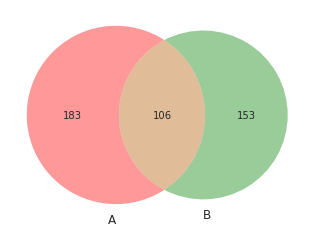

In [240]:
venn2([set_1,set_2])

In [201]:
nodos_cluster = graph_node_data.loc[graph_node_data.comunidades_infomap == ejemplo, "node_index"].values
matrix_jaccard_cluster = np.zeros((len(nodos_cluster), len(nodos_cluster)))
nodos_cluster = list(set(nodos_cluster)&set(nodos_enfermedad))

for i in range(len(nodos_cluster)):
    for j in range(len(nodos_cluster)):
        nodo_i = nodos_cluster[i]
        nodo_j = nodos_cluster[j]
        conjunto_i = conjuntos_enfermedad[nodo_i]
        conjunto_j = conjuntos_enfermedad[nodo_j]
        coef = jaccard(conjunto_i, conjunto_j)
        matrix_jaccard_cluster[i,j] = coef

In [203]:
nodos_cluster = graph_node_data.loc[graph_node_data.comunidades_infomap == ejemplo, "node_index"].values
matrix_overlap_cluster = np.zeros((len(nodos_cluster), len(nodos_cluster)))
nodos_cluster = list(set(nodos_cluster)&set(nodos_enfermedad))

for i in range(len(nodos_cluster)):
    for j in range(len(nodos_cluster)):
        nodo_i = nodos_cluster[i]
        nodo_j = nodos_cluster[j]
        conjunto_i = conjuntos_enfermedad[nodo_i]
        conjunto_j = conjuntos_enfermedad[nodo_j]
        coef = overlap(conjunto_i, conjunto_j)
        matrix_overlap_cluster[i,j] = coef

In [204]:
matrix_overlap_cluster

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [76]:
indices = np.triu_indices_from(matrix_jaccard_cluster,1)
values = matrix_jaccard_cluster[indices]

In [205]:
indices = np.triu_indices_from(matrix_overlap_cluster,1)
values = matrix_overlap_cluster[indices]

In [83]:
pd.DataFrame(matrix_jaccard_cluster, index=nodos_cluster, columns=nodos_cluster)

,25027,22405,26672,22546,25017,24029
25027,1.00,0.01,0.00,0.01,0.02,0.03
22405,0.01,1.00,0.00,1.00,0.06,0.03
26672,0.00,0.00,1.00,0.00,0.07,0.03
22546,0.01,1.00,0.00,1.00,0.06,0.03
25017,0.02,0.06,0.07,0.06,1.00,0.29
24029,0.03,0.03,0.03,0.03,0.29,1.00


In [156]:
df_overlap_sparse.loc[nodos_cluster,nodos_cluster]

,25027,22405,26672,22546,25017,24029
25027,1.000000,1.00,1.0,1.00,0.714286,0.500000
22405,1.000000,1.00,0.0,1.00,0.250000,0.250000
26672,1.000000,0.00,1.0,0.00,1.000000,1.000000
22546,1.000000,1.00,0.0,1.00,0.250000,0.250000
25017,0.714286,0.25,1.0,0.25,1.000000,0.714286
24029,0.500000,0.25,1.0,0.25,0.714286,1.000000


In [84]:
sparse_jaccard_test = sparse.csr_matrix(matrix_jaccard_cluster)
df_jaccard_sparse_test = pd.DataFrame.sparse.from_spmatrix(sparse_jaccard_test, index=nodos_cluster, columns=nodos_cluster)

In [157]:
mean_similarity_triu(df_overlap_sparse,ejemplo,"comunidades_infomap")

0.6

In [115]:
df_jaccard_sparse.loc[nodos_cluster,nodos_cluster]

,25027,22405,26672,22546,25017,24029
25027,1.00,0.01,0.00,0.01,0.02,0.03
22405,0.01,1.00,0.00,1.00,0.06,0.03
26672,0.00,0.00,1.00,0.00,0.07,0.03
22546,0.01,1.00,0.00,1.00,0.06,0.03
25017,0.02,0.06,0.07,0.06,1.00,0.29
24029,0.03,0.03,0.03,0.03,0.29,1.00


# Visualizaciones

In [175]:
all_data_infomap = pd.merge(infomap_clusters, conectividad_infomap, left_on="comunidad", right_on="comunidad")

def facet_range(x):
    if x <= 0.3:
        return 1
    elif x <= 0.6:
        return 2
    else:
        return 3

all_data_infomap["rangos_fraccion"] =  all_data_infomap.fraccion_gda.apply(lambda x: facet_range(x))

In [182]:
fig = px.histogram(all_data_infomap, x="jaccard_mean_similarity", facet_col="rangos_fraccion")
fig.show()

In [183]:
all_data_infomap

,comunidad,tamaño_x,jaccard_mean_similarity,mean_overlap_coef,tamaño_y,fraccion_gda,grado_gda_medio,max_grado_gda,rangos_fraccion
0,3,198,0.00,0.00,198,0.86,2.79,109.0,3
1,354,82,0.01,0.04,82,0.79,1.74,12.0,3
2,188,74,0.00,0.01,74,0.99,1.75,24.0,3
3,416,74,0.00,0.03,74,0.93,2.54,104.0,3
4,436,71,0.02,0.12,71,0.75,3.26,37.0,3
...,...,...,...,...,...,...,...,...,...
1136,968,2,0.25,0.50,2,1.00,5.00,6.0,3
1137,1060,2,1.00,1.00,2,1.00,4.00,4.0,3
1138,1010,2,1.00,1.00,2,1.00,4.00,4.0,3
1139,1121,2,NaN,NaN,2,0.50,2.00,2.0,2
